In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
from copy import deepcopy
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
from torchvision import datasets
from collections import defaultdict
from torch.utils.data import random_split, Dataset
from torchvision import datasets, transforms
from dataset_wrappers import TransformedDataset

In [2]:
def load_animals_pictures(data_dir="./raw-img", train_ratio=0.8):
    translate = {
        "cane": "dog",
        "cavallo": "horse",
        "elefante": "elephant",
        "farfalla": "butterfly",
        "gallina": "chicken",
        "gatto": "cat",
        "mucca": "cow",
        "pecora": "sheep",
        "ragno": "spider",
        "scoiattolo": "squirrel"
    }
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    dataset = datasets.ImageFolder(root=data_dir, transform=transform)

    old_classes = dataset.classes
    new_classes = [translate[c] for c in old_classes]
    dataset.classes = new_classes

    dataset.class_to_idx = {
        translate[k]: v for k, v in dataset.class_to_idx.items()
    }

    dataset_size = len(dataset)
    train_size = int(train_ratio * dataset_size)
    test_size = dataset_size - train_size

    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    return train_dataset, test_dataset

In [3]:
try:
    train_dataset, test_dataset = load_animals_pictures()
    print("Data successfully downloaded and unpacked!")
    print(f"Training set size: {len(train_dataset)} images")
    print(f"Test set size: {len(test_dataset)} images")
except Exception as e:
    print(f"Data loading error: {e}")

Data successfully downloaded and unpacked!
Training set size: 20943 images
Test set size: 5236 images


In [4]:
print(train_dataset.dataset.classes)

['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']


In [5]:
def denormalize(image):
    return image * 0.5 + 0.5

In [6]:
def imshow(image):
    image = denormalize(image)
    npimg = image.numpy() if isinstance(image, torch.Tensor) else image
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [8]:
def show_img(dataset):
    data_iter = iter(dataset)
    samples = [next(data_iter) for _ in range(5)]

    plt.figure(figsize=(10, 5))
    for i, (image, label) in enumerate(samples):
        plt.subplot(1, 5, i+1)
        imshow(image)
        plt.title(train_dataset.dataset.classes[label])
        plt.axis("off")

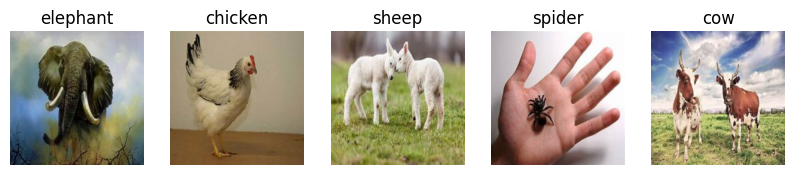

In [9]:
show_img(train_dataset)

In [9]:
class_count = defaultdict(int)

for _, label in train_dataset:
    class_name = train_dataset.dataset.classes[label]
    class_count[class_name] += 1

In [11]:
print("Number of images in each class:\n")
for class_name, count in class_count.items():
    print(f"{class_name}: {count} images")

Number of images in each class:

butterfly: 1702 images
dog: 3902 images
cat: 1305 images
sheep: 1464 images
spider: 3827 images
cow: 1499 images
chicken: 2480 images
horse: 2123 images
squirrel: 1479 images
elephant: 1162 images


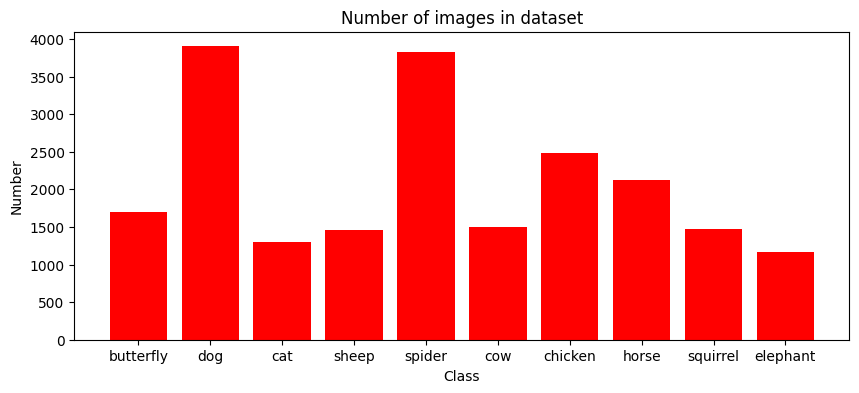

In [10]:
plt.figure(figsize=(10,4))
plt.bar(class_count.keys(), class_count.values(), color="r")
plt.title("Number of images in dataset")
plt.xlabel("Class")
plt.ylabel("Number")
plt.show()

In [10]:
random_seed = 42
torch.manual_seed(random_seed);

In [11]:
val_size = int(len(train_dataset) * 0.2)
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

In [12]:
print(f"Number of images in train_ds: {len(train_ds)}")
print(f"Number of images in val_ds: {len(val_ds)}")

Number of images in train_ds: 16755
Number of images in val_ds: 4188


In [13]:
transform_train_data = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2)])

In [14]:
batch_size = 64

In [15]:
transformed_train_dataset = TransformedDataset(train_ds, transform_train_data)
transformed_val_dataset = TransformedDataset(val_ds)
transformed_test_dataset = TransformedDataset(test_dataset)

train_DataLoader = DataLoader(transformed_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_DataLoader = DataLoader(transformed_val_dataset, batch_size=batch_size*2, num_workers=2, pin_memory=True)
test_DataLoader = DataLoader(transformed_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [16]:
print(f"Number of images in train_dl: {len(train_DataLoader)}")
print(f"Number of images in val_dl: {len(val_DataLoader)}")
print(f"Number of images in test_loader: {len(test_DataLoader)}")

Number of images in train_dl: 262
Number of images in val_dl: 33
Number of images in test_loader: 82


In [17]:
def show_batch(dl):
    for images, labels in dl:
        images = (images + 1) / 2
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break

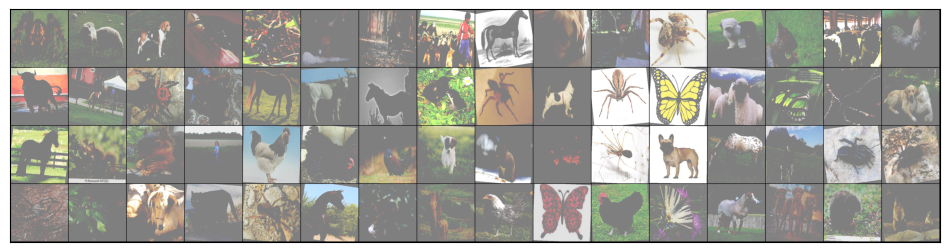

In [18]:
show_batch(train_DataLoader)

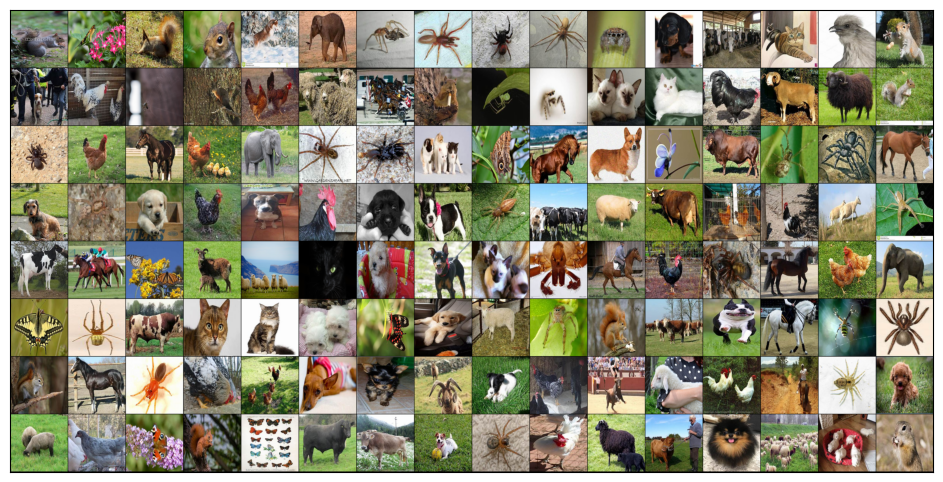

In [24]:
show_batch(val_DataLoader)

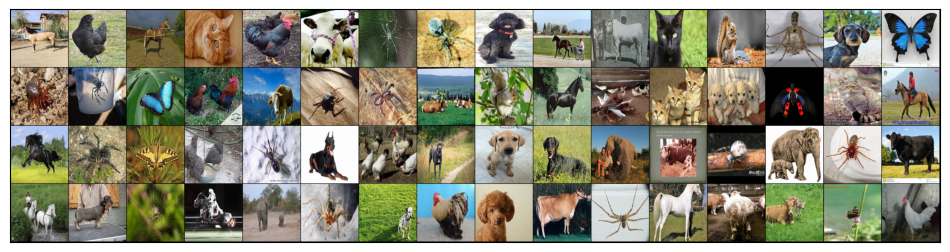

In [23]:
show_batch(test_DataLoader)

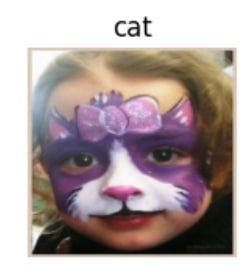